## Cle Elum Ridge (CER) Treatment Manuscript Scripts 
## `3_update_netcdf_all_variables` 
### Script to update the simple netcdf to create all the random variables needed for analysis

Notebook contents 
* Import all raw tif files and create a simple netcdf file for future analysis 
* Check datasets for nans, out of range values, and do simple cleaning 

created by Cassie Lumbrazo\
last updated: June 2024\
run location: locally\
python environment: **raster**

In [1]:
# import packages 
%matplotlib inline

# plotting packages 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns 

sns.set_theme()
# plt.rcParams['figure.figsize'] = [12,6] #overriding size

# data packages 
import pandas as pd
import numpy as np
import xarray as xr
from datetime import datetime

# import csv 
# import copy 
# import os.path 

# import geopandas as gpd
# import rasterio
# from rasterio.warp import calculate_default_transform, reproject, Resampling
# import rioxarray
# import rasterio

import scipy

In [2]:
# Paths for local machine
ds = xr.open_dataset('C:\\Users\\Lumbr\\OneDrive - UW/Documents\\Washington\\EasternCascades\\Python\\CER_treatment_manuscript\\cer_treatment_region_dataset_simple.nc') 

In [3]:
ds

<xarray.Dataset>
Dimensions:             (x: 2564, y: 1388, band: 1)
Coordinates:
  * x                   (x) float64 4.65e+05 4.65e+05 ... 4.676e+05 4.676e+05
  * y                   (y) float64 2.111e+05 2.111e+05 ... 2.097e+05 2.097e+05
  * band                (band) int32 1
    spatial_ref         int32 ...
Data variables: (12/30)
    chmws_rapid         (band, y, x) float32 ...
    dce_rapid           (band, y, x) float32 ...
    giulia_dce_rapid    (band, y, x) float32 ...
    giulia_dce_ncalm    (band, y, x) float32 ...
    baf_old             (band, y, x) float32 ...
    baf_new             (band, y, x) float32 ...
    ...                  ...
    hs_ncalm            (band, y, x) float32 ...
    dem                 (band, y, x) float32 ...
    hs_rapid            (band, y, x) float32 ...
    chmas_rapid         (band, y, x) float32 ...
    dtm_rapid           (band, y, x) float32 ...
    dsm_rapid           (band, y, x) float32 ...

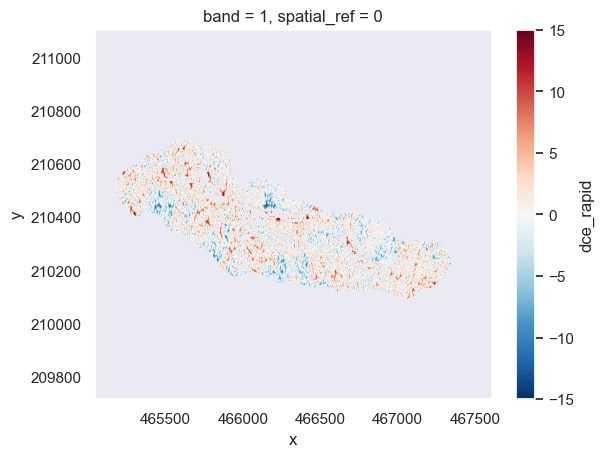

In [5]:
ds['dce_rapid'].plot()

In [8]:
# temporary code to fix the units, remove once I fix the netcdf 
ds['dce_ncalm'] = ds['dce_ncalm'] / 0.3048

# recalculate the differences
ds['diff_dce_rapid_ncalm'] = ds['dce_rapid'] - ds['dce_ncalm']

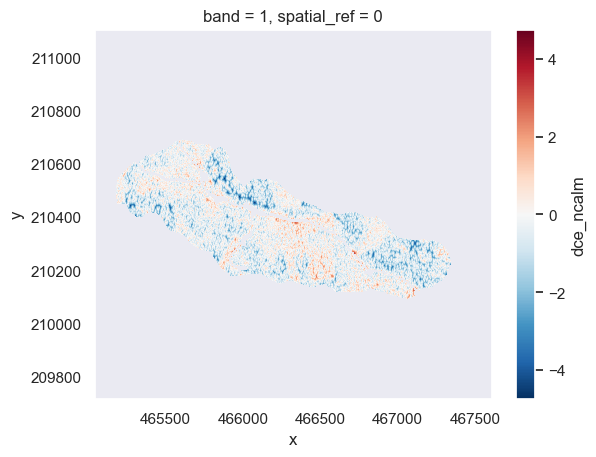

In [6]:
ds['dce_ncalm'].plot()

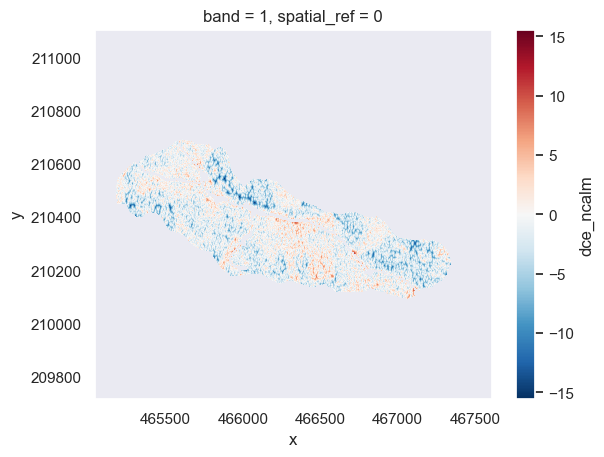

In [9]:
ds['dce_ncalm'].plot()

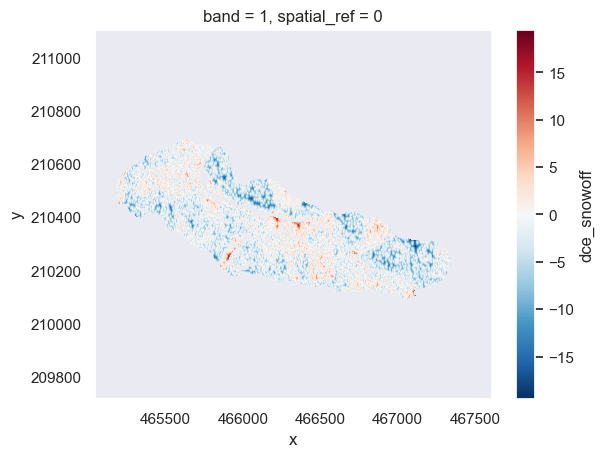

In [7]:
ds['dce_snowoff'].plot()

In [11]:
# # # save this dataset as a netcdf 
# ds.to_netcdf('C:\\Users\\Lumbr\\OneDrive - UW/Documents\\Washington\\EasternCascades\\Python\\CER_treatment_manuscript\\cer_treatment_region_dataset_simple_fixed.nc') # for the snow depth values cut a zero

### Now, let's start creating new variables with calculations and such. 

In [12]:
# canopy height model differences
ds['diff_chm_rapid_snowoff'] = ds['chmws_rapid'] - ds['chm_snowoff']
ds['diff_chm_ncalm_snowoff'] = ds['chmws_ncalm'] - ds['chm_snowoff']
ds['diff_chm_rapid_ncalm'] =   ds['chmws_rapid'] - ds['chmws_ncalm']

ds['diff_chm_snowoff_rapid'] =  ds['chm_snowoff']- ds['chmws_rapid']
ds['diff_chm_snowoff_ncalm'] =  ds['chm_snowoff']- ds['chmws_ncalm']
ds['diff_chm_ncalm_rapid'] =    ds['chmws_ncalm']- ds['chmws_rapid'] 

# dce differences 
ds['diff_dce_rapid_ncalm'] = ds['dce_rapid'] - ds['dce_ncalm']
ds['diff_dce_rapid_ncalm'] = ds['dce_rapid'] - ds['dce_snowoff']
ds['diff_giulia_dce_rapid_ncalm'] = ds['giulia_dce_rapid'] - ds['giulia_dce_ncalm']
ds['diff_giulia_dce_rapid_snowoff'] = ds['giulia_dce_rapid'] - ds['giulia_dce_snowoff']

# snow depth differences
ds['diff_hs_rapid_ncalm'] = ds['hs_rapid'] - ds['hs_ncalm']

Calculations for aspect and binary dah

In [13]:
# create binary object for dah
ds['dah_binary'] = np.nan
ds['dah_binary'] = ds['dah_binary'].where(~(ds['dah'] >= 0),  1)  # where DAH is greater than 0, then 1 for high heat index
ds['dah_binary'] = ds['dah_binary'].where(~(ds['dah'] <  0), -1)  # where DAH is less than or equal to 0, then -1 for low heat index

# and, make the baf_ridge binary 
ds['baf_ridge'] = ds['baf_ridge'].where(~(ds['baf_ridge'] >= 0),  1) # where not false (true) fill with 1 (south)
ds['baf_ridge'] = ds['baf_ridge'].where(~(ds['baf_ridge'] <  0), -1) # where not false (true) fill with -1 (north)

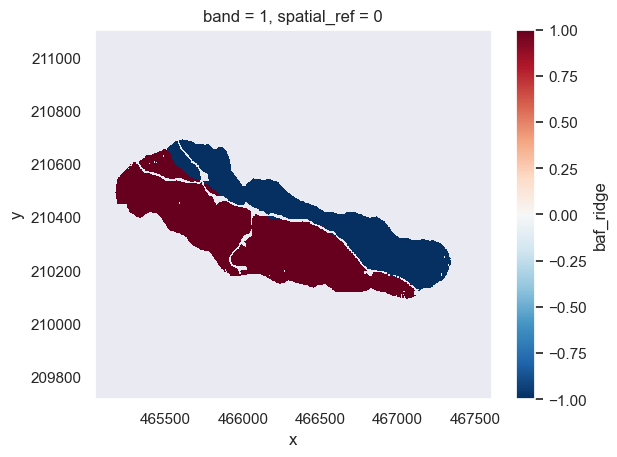

In [14]:
ds['baf_ridge'].plot()

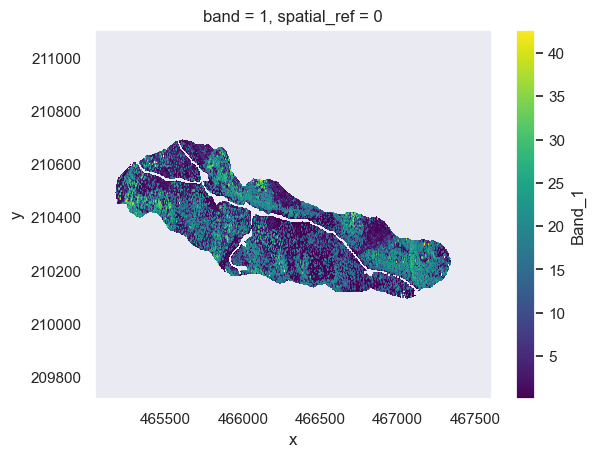

In [15]:
ds['chm_snowoff'].plot()

Now, create distance to canopy edge groups 

In [16]:
# fix up dce classification so that it's clear groups
# xarray .where function becomes a mask when you use the ~ to negate the statement 

dce_reclass = ds['dce_snowoff'].copy(deep=True) # where cond = False, replace (unless we use the ~)                                

dce_reclass = dce_reclass.where(~(dce_reclass > 60), drop=True)                       # droping any gaps that are bigger than 20
dce_reclass = dce_reclass.where(~(( 3 <  dce_reclass) & (dce_reclass <=  60)), 500) # group 1: Large Gaps      3 <  DCE <=  20
dce_reclass = dce_reclass.where(~(( 1 <  dce_reclass) & (dce_reclass <=  3)), 400) # group 2: Small Gaps      1 <  DCE <=  3
dce_reclass = dce_reclass.where(~((-1 <= dce_reclass) & (dce_reclass <=  1)), 300) # group 3: Edges          -1 <= DCE <=  1
dce_reclass = dce_reclass.where(~((-3 <= dce_reclass) & (dce_reclass <  -1)), 200) # group 4: Small Clusters -3 <= DCE <=  1
dce_reclass = dce_reclass.where(~(dce_reclass <-3), 100)                           # group 5: Large Clusters       DCE <= -3

ds['dce_snowoff_reclass'] = dce_reclass.copy(deep=True)

# Also saving these into the xarray dataframe, then else is nan for each group 
# only for my dce classification, but Giulia's for now 
ds['dce_snowoff_largeclusters'] = ds.dce_snowoff_reclass.where(ds.dce_snowoff_reclass == 100)
ds['dce_snowoff_smallclusters'] = ds.dce_snowoff_reclass.where(ds.dce_snowoff_reclass == 200)
ds['dce_snowoff_canopyedges']   = ds.dce_snowoff_reclass.where(ds.dce_snowoff_reclass == 300)
ds['dce_snowoff_smallgaps']     = ds.dce_snowoff_reclass.where(ds.dce_snowoff_reclass == 400)
ds['dce_snowoff_largegaps']     = ds.dce_snowoff_reclass.where(ds.dce_snowoff_reclass == 500)

In [17]:
# fix up dce classification so that it's clear groups
# xarray .where function becomes a mask when you use the ~ to negate the statement 

dce_reclass = ds['dce_rapid'].copy(deep=True) # where cond = False, replace (unless we use the ~)                                

dce_reclass = dce_reclass.where(~(dce_reclass > 60), drop=True)                       # droping any gaps that are bigger than 20
dce_reclass = dce_reclass.where(~(( 3 <  dce_reclass) & (dce_reclass <=  60)), 500) # group 1: Large Gaps      3 <  DCE <=  20
dce_reclass = dce_reclass.where(~(( 1 <  dce_reclass) & (dce_reclass <=  3)), 400) # group 2: Small Gaps      1 <  DCE <=  3
dce_reclass = dce_reclass.where(~((-1 <= dce_reclass) & (dce_reclass <=  1)), 300) # group 3: Edges          -1 <= DCE <=  1
dce_reclass = dce_reclass.where(~((-3 <= dce_reclass) & (dce_reclass <  -1)), 200) # group 4: Small Clusters -3 <= DCE <=  1
dce_reclass = dce_reclass.where(~(dce_reclass <-3), 100)                           # group 5: Large Clusters       DCE <= -3

ds['dce_rapid_reclass'] = dce_reclass.copy(deep=True)

# Also saving these into the xarray dataframe, then else is nan for each group 
# only for my dce classification, but Giulia's for now 
ds['dce_rapid_largeclusters'] = ds.dce_rapid_reclass.where(ds.dce_rapid_reclass == 100)
ds['dce_rapid_smallclusters'] = ds.dce_rapid_reclass.where(ds.dce_rapid_reclass == 200)
ds['dce_rapid_canopyedges']   = ds.dce_rapid_reclass.where(ds.dce_rapid_reclass == 300)
ds['dce_rapid_smallgaps']     = ds.dce_rapid_reclass.where(ds.dce_rapid_reclass == 400)
ds['dce_rapid_largegaps']     = ds.dce_rapid_reclass.where(ds.dce_rapid_reclass == 500)

In [18]:
# fix up dce classification so that it's clear groups
# xarray .where function becomes a mask when you use the ~ to negate the statement 

dce_reclass = ds['dce_ncalm'].copy(deep=True) # where cond = False, replace (unless we use the ~)                                

dce_reclass = dce_reclass.where(~(dce_reclass > 60), drop=True)                       # droping any gaps that are bigger than 20
dce_reclass = dce_reclass.where(~(( 3 <  dce_reclass) & (dce_reclass <=  60)), 500) # group 1: Large Gaps      3 <  DCE <=  20
dce_reclass = dce_reclass.where(~(( 1 <  dce_reclass) & (dce_reclass <=  3)), 400) # group 2: Small Gaps      1 <  DCE <=  3
dce_reclass = dce_reclass.where(~((-1 <= dce_reclass) & (dce_reclass <=  1)), 300) # group 3: Edges          -1 <= DCE <=  1
dce_reclass = dce_reclass.where(~((-3 <= dce_reclass) & (dce_reclass <  -1)), 200) # group 4: Small Clusters -3 <= DCE <=  1
dce_reclass = dce_reclass.where(~(dce_reclass <-3), 100)                           # group 5: Large Clusters       DCE <= -3

ds['dce_ncalm_reclass'] = dce_reclass.copy(deep=True)

# Also saving these into the xarray dataframe, then else is nan for each group 
# only for my dce classification, but Giulia's for now 
ds['dce_ncalm_largeclusters'] = ds.dce_ncalm_reclass.where(ds.dce_ncalm_reclass == 100)
ds['dce_ncalm_smallclusters'] = ds.dce_ncalm_reclass.where(ds.dce_ncalm_reclass == 200)
ds['dce_ncalm_canopyedges']   = ds.dce_ncalm_reclass.where(ds.dce_ncalm_reclass == 300)
ds['dce_ncalm_smallgaps']     = ds.dce_ncalm_reclass.where(ds.dce_ncalm_reclass == 400)
ds['dce_ncalm_largegaps']     = ds.dce_ncalm_reclass.where(ds.dce_ncalm_reclass == 500)

Now, do the same with the two Giulia DCE versions. 

In [19]:
# fix up dce classification so that it's clear groups
# xarray .where function becomes a mask when you use the ~ to negate the statement 

dce_reclass = ds['giulia_dce_snowoff'].copy(deep=True) # where cond = False, replace (unless we use the ~)                                

dce_reclass = dce_reclass.where(~(dce_reclass > 60), drop=True)                       # droping any gaps that are bigger than 20
dce_reclass = dce_reclass.where(~(( 3 <  dce_reclass) & (dce_reclass <=  60)), 500) # group 1: Large Gaps      3 <  DCE <=  20
dce_reclass = dce_reclass.where(~(( 1 <  dce_reclass) & (dce_reclass <=  3)), 400) # group 2: Small Gaps      1 <  DCE <=  3
dce_reclass = dce_reclass.where(~((-1 <= dce_reclass) & (dce_reclass <=  1)), 300) # group 3: Edges          -1 <= DCE <=  1
dce_reclass = dce_reclass.where(~((-3 <= dce_reclass) & (dce_reclass <  -1)), 200) # group 4: Small Clusters -3 <= DCE <=  1
dce_reclass = dce_reclass.where(~(dce_reclass <-3), 100)                           # group 5: Large Clusters       DCE <= -3

ds['giulia_dce_snowoff_reclass'] = dce_reclass.copy(deep=True)

# Also saving these into the xarray dataframe, then else is nan for each group 
# only for my dce classification, but Giulia's for now 
ds['giulia_dce_snowoff_largeclusters'] = ds.giulia_dce_snowoff_reclass.where(ds.giulia_dce_snowoff_reclass == 100)
ds['giulia_dce_snowoff_smallclusters'] = ds.giulia_dce_snowoff_reclass.where(ds.giulia_dce_snowoff_reclass == 200)
ds['giulia_dce_snowoff_canopyedges']   = ds.giulia_dce_snowoff_reclass.where(ds.giulia_dce_snowoff_reclass == 300)
ds['giulia_dce_snowoff_smallgaps']     = ds.giulia_dce_snowoff_reclass.where(ds.giulia_dce_snowoff_reclass == 400)
ds['giulia_dce_snowoff_largegaps']     = ds.giulia_dce_snowoff_reclass.where(ds.giulia_dce_snowoff_reclass == 500)

In [20]:
# fix up dce classification so that it's clear groups
# xarray .where function becomes a mask when you use the ~ to negate the statement 

dce_reclass = ds['giulia_dce_rapid'].copy(deep=True) # where cond = False, replace (unless we use the ~)                                

dce_reclass = dce_reclass.where(~(dce_reclass > 60), drop=True)                       # droping any gaps that are bigger than 20
dce_reclass = dce_reclass.where(~(( 3 <  dce_reclass) & (dce_reclass <=  60)), 500) # group 1: Large Gaps      3 <  DCE <=  20
dce_reclass = dce_reclass.where(~(( 1 <  dce_reclass) & (dce_reclass <=  3)), 400) # group 2: Small Gaps      1 <  DCE <=  3
dce_reclass = dce_reclass.where(~((-1 <= dce_reclass) & (dce_reclass <=  1)), 300) # group 3: Edges          -1 <= DCE <=  1
dce_reclass = dce_reclass.where(~((-3 <= dce_reclass) & (dce_reclass <  -1)), 200) # group 4: Small Clusters -3 <= DCE <=  1
dce_reclass = dce_reclass.where(~(dce_reclass <-3), 100)                           # group 5: Large Clusters       DCE <= -3

ds['giulia_dce_rapid_reclass'] = dce_reclass.copy(deep=True)

# Also saving these into the xarray dataframe, then else is nan for each group 
# only for my dce classification, but Giulia's for now 
ds['giulia_dce_rapid_largeclusters'] = ds.giulia_dce_rapid_reclass.where(ds.giulia_dce_rapid_reclass == 100)
ds['giulia_dce_rapid_smallclusters'] = ds.giulia_dce_rapid_reclass.where(ds.giulia_dce_rapid_reclass == 200)
ds['giulia_dce_rapid_canopyedges']   = ds.giulia_dce_rapid_reclass.where(ds.giulia_dce_rapid_reclass == 300)
ds['giulia_dce_rapid_smallgaps']     = ds.giulia_dce_rapid_reclass.where(ds.giulia_dce_rapid_reclass == 400)
ds['giulia_dce_rapid_largegaps']     = ds.giulia_dce_rapid_reclass.where(ds.giulia_dce_rapid_reclass == 500)

In [21]:
# fix up dce classification so that it's clear groups
# xarray .where function becomes a mask when you use the ~ to negate the statement 

dce_reclass = ds['giulia_dce_ncalm'].copy(deep=True) # where cond = False, replace (unless we use the ~)                                

dce_reclass = dce_reclass.where(~(dce_reclass > 60), drop=True)                       # droping any gaps that are bigger than 20
dce_reclass = dce_reclass.where(~(( 3 <  dce_reclass) & (dce_reclass <=  60)), 500) # group 1: Large Gaps      3 <  DCE <=  20
dce_reclass = dce_reclass.where(~(( 1 <  dce_reclass) & (dce_reclass <=  3)), 400) # group 2: Small Gaps      1 <  DCE <=  3
dce_reclass = dce_reclass.where(~((-1 <= dce_reclass) & (dce_reclass <=  1)), 300) # group 3: Edges          -1 <= DCE <=  1
dce_reclass = dce_reclass.where(~((-3 <= dce_reclass) & (dce_reclass <  -1)), 200) # group 4: Small Clusters -3 <= DCE <=  1
dce_reclass = dce_reclass.where(~(dce_reclass <-3), 100)                           # group 5: Large Clusters       DCE <= -3

ds['giulia_dce_ncalm_reclass'] = dce_reclass.copy(deep=True)

# Also saving these into the xarray dataframe, then else is nan for each group 
# only for my dce classification, but Giulia's for now 
ds['giulia_dce_ncalm_largeclusters'] = ds.giulia_dce_ncalm_reclass.where(ds.giulia_dce_ncalm_reclass == 100)
ds['giulia_dce_ncalm_smallclusters'] = ds.giulia_dce_ncalm_reclass.where(ds.giulia_dce_ncalm_reclass == 200)
ds['giulia_dce_ncalm_canopyedges']   = ds.giulia_dce_ncalm_reclass.where(ds.giulia_dce_ncalm_reclass == 300)
ds['giulia_dce_ncalm_smallgaps']     = ds.giulia_dce_ncalm_reclass.where(ds.giulia_dce_ncalm_reclass == 400)
ds['giulia_dce_ncalm_largegaps']     = ds.giulia_dce_ncalm_reclass.where(ds.giulia_dce_ncalm_reclass == 500)

if this is the dataset with the baf old and new still, let's get rid of that...

In [22]:
# drop the old baf values
ds['baf'] = ds['baf_new'].copy(deep=True)
ds = ds.drop_vars(['baf_old', 'baf_new'])

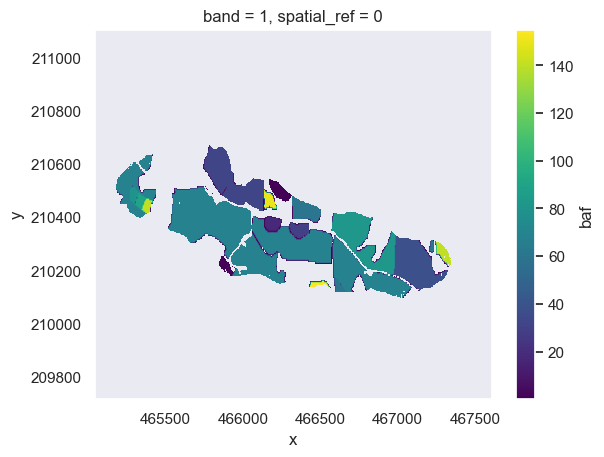

In [23]:
ds['baf'].plot()

And, start making the huge list of BAF variable groups that we need for later analysis

In [24]:
ds['dce_snowoff_baf_new_1'] = ds['dce_snowoff'].where(ds['baf'] == 1)
ds['dce_snowoff_baf_new_2'] = ds['dce_snowoff'].where(ds['baf'] == 2)
ds['dce_snowoff_baf_new_17'] = ds['dce_snowoff'].where(ds['baf'] == 17)
ds['dce_snowoff_baf_new_30'] = ds['dce_snowoff'].where(ds['baf'] == 30)
ds['dce_snowoff_baf_new_32'] = ds['dce_snowoff'].where(ds['baf'] == 32)
ds['dce_snowoff_baf_new_38'] = ds['dce_snowoff'].where(ds['baf'] == 38)
ds['dce_snowoff_baf_new_60'] = ds['dce_snowoff'].where(ds['baf'] == 60)
ds['dce_snowoff_baf_new_69'] = ds['dce_snowoff'].where(ds['baf'] == 69)
ds['dce_snowoff_baf_new_80'] = ds['dce_snowoff'].where(ds['baf'] == 80)
ds['dce_snowoff_baf_new_82'] = ds['dce_snowoff'].where(ds['baf'] == 82)
ds['dce_snowoff_baf_new_90'] = ds['dce_snowoff'].where(ds['baf'] == 90)
ds['dce_snowoff_baf_new_92'] = ds['dce_snowoff'].where(ds['baf'] == 92)
ds['dce_snowoff_baf_new_140'] = ds['dce_snowoff'].where(ds['baf'] == 140)
ds['dce_snowoff_baf_new_150'] = ds['dce_snowoff'].where(ds['baf'] == 150)
ds['dce_snowoff_baf_new_155'] = ds['dce_snowoff'].where(ds['baf'] == 155)

ds['dce_rapid_baf_new_1'] = ds['dce_rapid'].where(ds['baf'] == 1)
ds['dce_rapid_baf_new_2'] = ds['dce_rapid'].where(ds['baf'] == 2)
ds['dce_rapid_baf_new_17'] = ds['dce_rapid'].where(ds['baf'] == 17)
ds['dce_rapid_baf_new_30'] = ds['dce_rapid'].where(ds['baf'] == 30)
ds['dce_rapid_baf_new_32'] = ds['dce_rapid'].where(ds['baf'] == 32)
ds['dce_rapid_baf_new_38'] = ds['dce_rapid'].where(ds['baf'] == 38)
ds['dce_rapid_baf_new_60'] = ds['dce_rapid'].where(ds['baf'] == 60)
ds['dce_rapid_baf_new_69'] = ds['dce_rapid'].where(ds['baf'] == 69)
ds['dce_rapid_baf_new_80'] = ds['dce_rapid'].where(ds['baf'] == 80)
ds['dce_rapid_baf_new_82'] = ds['dce_rapid'].where(ds['baf'] == 82)
ds['dce_rapid_baf_new_90'] = ds['dce_rapid'].where(ds['baf'] == 90)
ds['dce_rapid_baf_new_92'] = ds['dce_rapid'].where(ds['baf'] == 92)
ds['dce_rapid_baf_new_140'] = ds['dce_rapid'].where(ds['baf'] == 140)
ds['dce_rapid_baf_new_150'] = ds['dce_rapid'].where(ds['baf'] == 150)
ds['dce_rapid_baf_new_155'] = ds['dce_rapid'].where(ds['baf'] == 155)

ds['dce_ncalm_baf_new_1'] = ds['dce_ncalm'].where(ds['baf'] == 1)
ds['dce_ncalm_baf_new_2'] = ds['dce_ncalm'].where(ds['baf'] == 2)
ds['dce_ncalm_baf_new_17'] = ds['dce_ncalm'].where(ds['baf'] == 17)
ds['dce_ncalm_baf_new_30'] = ds['dce_ncalm'].where(ds['baf'] == 30)
ds['dce_ncalm_baf_new_32'] = ds['dce_ncalm'].where(ds['baf'] == 32)
ds['dce_ncalm_baf_new_38'] = ds['dce_ncalm'].where(ds['baf'] == 38)
ds['dce_ncalm_baf_new_60'] = ds['dce_ncalm'].where(ds['baf'] == 60)
ds['dce_ncalm_baf_new_69'] = ds['dce_ncalm'].where(ds['baf'] == 69)
ds['dce_ncalm_baf_new_80'] = ds['dce_ncalm'].where(ds['baf'] == 80)
ds['dce_ncalm_baf_new_82'] = ds['dce_ncalm'].where(ds['baf'] == 82)
ds['dce_ncalm_baf_new_90'] = ds['dce_ncalm'].where(ds['baf'] == 90)
ds['dce_ncalm_baf_new_92'] = ds['dce_ncalm'].where(ds['baf'] == 92)
ds['dce_ncalm_baf_new_140'] = ds['dce_ncalm'].where(ds['baf'] == 140)
ds['dce_ncalm_baf_new_150'] = ds['dce_ncalm'].where(ds['baf'] == 150)
ds['dce_ncalm_baf_new_155'] = ds['dce_ncalm'].where(ds['baf'] == 155)

ds['giulia_dce_rapid_baf_new_1'] = ds['giulia_dce_rapid'].where(ds['baf'] == 1)
ds['giulia_dce_rapid_baf_new_2'] = ds['giulia_dce_rapid'].where(ds['baf'] == 2)
ds['giulia_dce_rapid_baf_new_17'] = ds['giulia_dce_rapid'].where(ds['baf'] == 17)
ds['giulia_dce_rapid_baf_new_30'] = ds['giulia_dce_rapid'].where(ds['baf'] == 30)
ds['giulia_dce_rapid_baf_new_32'] = ds['giulia_dce_rapid'].where(ds['baf'] == 32)
ds['giulia_dce_rapid_baf_new_38'] = ds['giulia_dce_rapid'].where(ds['baf'] == 38)
ds['giulia_dce_rapid_baf_new_60'] = ds['giulia_dce_rapid'].where(ds['baf'] == 60)
ds['giulia_dce_rapid_baf_new_69'] = ds['giulia_dce_rapid'].where(ds['baf'] == 69)
ds['giulia_dce_rapid_baf_new_80'] = ds['giulia_dce_rapid'].where(ds['baf'] == 80)
ds['giulia_dce_rapid_baf_new_82'] = ds['giulia_dce_rapid'].where(ds['baf'] == 82)
ds['giulia_dce_rapid_baf_new_90'] = ds['giulia_dce_rapid'].where(ds['baf'] == 90)
ds['giulia_dce_rapid_baf_new_92'] = ds['giulia_dce_rapid'].where(ds['baf'] == 92)
ds['giulia_dce_rapid_baf_new_140'] = ds['giulia_dce_rapid'].where(ds['baf'] == 140)
ds['giulia_dce_rapid_baf_new_150'] = ds['giulia_dce_rapid'].where(ds['baf'] == 150)
ds['giulia_dce_rapid_baf_new_155'] = ds['giulia_dce_rapid'].where(ds['baf'] == 155)

# would add giulia dce ncalm here if we had it
ds['giulia_dce_ncalm_baf_new_1'] = ds['giulia_dce_ncalm'].where(ds['baf'] == 1)
ds['giulia_dce_ncalm_baf_new_2'] = ds['giulia_dce_ncalm'].where(ds['baf'] == 2)
ds['giulia_dce_ncalm_baf_new_17'] = ds['giulia_dce_ncalm'].where(ds['baf'] == 17)
ds['giulia_dce_ncalm_baf_new_30'] = ds['giulia_dce_ncalm'].where(ds['baf'] == 30)
ds['giulia_dce_ncalm_baf_new_32'] = ds['giulia_dce_ncalm'].where(ds['baf'] == 32)
ds['giulia_dce_ncalm_baf_new_38'] = ds['giulia_dce_ncalm'].where(ds['baf'] == 38)
ds['giulia_dce_ncalm_baf_new_60'] = ds['giulia_dce_ncalm'].where(ds['baf'] == 60)
ds['giulia_dce_ncalm_baf_new_69'] = ds['giulia_dce_ncalm'].where(ds['baf'] == 69)
ds['giulia_dce_ncalm_baf_new_80'] = ds['giulia_dce_ncalm'].where(ds['baf'] == 80)
ds['giulia_dce_ncalm_baf_new_82'] = ds['giulia_dce_ncalm'].where(ds['baf'] == 82)
ds['giulia_dce_ncalm_baf_new_90'] = ds['giulia_dce_ncalm'].where(ds['baf'] == 90)
ds['giulia_dce_ncalm_baf_new_92'] = ds['giulia_dce_ncalm'].where(ds['baf'] == 92)
ds['giulia_dce_ncalm_baf_new_140'] = ds['giulia_dce_ncalm'].where(ds['baf'] == 140)
ds['giulia_dce_ncalm_baf_new_150'] = ds['giulia_dce_ncalm'].where(ds['baf'] == 150)
ds['giulia_dce_ncalm_baf_new_155'] = ds['giulia_dce_ncalm'].where(ds['baf'] == 155)

ds['giulia_dce_snowoff_baf_new_1'] = ds['giulia_dce_snowoff'].where(ds['baf'] == 1)
ds['giulia_dce_snowoff_baf_new_2'] = ds['giulia_dce_snowoff'].where(ds['baf'] == 2)
ds['giulia_dce_snowoff_baf_new_17'] = ds['giulia_dce_snowoff'].where(ds['baf'] == 17)
ds['giulia_dce_snowoff_baf_new_30'] = ds['giulia_dce_snowoff'].where(ds['baf'] == 30)
ds['giulia_dce_snowoff_baf_new_32'] = ds['giulia_dce_snowoff'].where(ds['baf'] == 32)
ds['giulia_dce_snowoff_baf_new_38'] = ds['giulia_dce_snowoff'].where(ds['baf'] == 38)
ds['giulia_dce_snowoff_baf_new_60'] = ds['giulia_dce_snowoff'].where(ds['baf'] == 60)
ds['giulia_dce_snowoff_baf_new_69'] = ds['giulia_dce_snowoff'].where(ds['baf'] == 69)
ds['giulia_dce_snowoff_baf_new_80'] = ds['giulia_dce_snowoff'].where(ds['baf'] == 80)
ds['giulia_dce_snowoff_baf_new_82'] = ds['giulia_dce_snowoff'].where(ds['baf'] == 82)
ds['giulia_dce_snowoff_baf_new_90'] = ds['giulia_dce_snowoff'].where(ds['baf'] == 90)
ds['giulia_dce_snowoff_baf_new_92'] = ds['giulia_dce_snowoff'].where(ds['baf'] == 92)
ds['giulia_dce_snowoff_baf_new_140'] = ds['giulia_dce_snowoff'].where(ds['baf'] == 140)
ds['giulia_dce_snowoff_baf_new_150'] = ds['giulia_dce_snowoff'].where(ds['baf'] == 150)
ds['giulia_dce_snowoff_baf_new_155'] = ds['giulia_dce_snowoff'].where(ds['baf'] == 155)

Now, let's group the new bafs into areas that are more simple for future plotting...

In [25]:
ds['baf_new_grouped'] = ds['baf'].copy(deep=True)
# 1 can just be it's own group, which is the leave gaps 
# 2 is the leave forest... 
# 17 is the beauty cuts... 
ds['baf_new_grouped'] = ds['baf_new_grouped'].where(~((ds['baf'] == 30) | (ds['baf'] == 32) | (ds['baf'] == 38)), 30) 
ds['baf_new_grouped'] = ds['baf_new_grouped'].where(~((ds['baf'] == 60) | (ds['baf'] == 69)), 60)
ds['baf_new_grouped'] = ds['baf_new_grouped'].where(~((ds['baf'] == 80) | (ds['baf'] == 82)), 80)
ds['baf_new_grouped'] = ds['baf_new_grouped'].where(~((ds['baf'] == 90) | (ds['baf'] == 92)), 90)
ds['baf_new_grouped'] = ds['baf_new_grouped'].where(~(ds['baf'] > 130), 150) # 140,150, 155 together

In [26]:
ds['dce_snowoff_baf_new_30s'] = ds['dce_snowoff'].where(ds['baf_new_grouped'] == 30)
ds['dce_snowoff_baf_new_60s'] = ds['dce_snowoff'].where(ds['baf_new_grouped'] == 60)
ds['dce_snowoff_baf_new_80s'] = ds['dce_snowoff'].where(ds['baf_new_grouped'] == 80)
ds['dce_snowoff_baf_new_90s'] = ds['dce_snowoff'].where(ds['baf_new_grouped'] == 90)
ds['dce_snowoff_baf_new_100s'] = ds['dce_snowoff'].where(ds['baf_new_grouped'] == 150)

#ds['dce_rapid_baf_new_1'] = ds['dce_rapid'].where(ds['baf_new_grouped'] == 1)
#ds['dce_rapid_baf_new_2'] = ds['dce_rapid'].where(ds['baf_new_grouped'] == 2)
ds['dce_rapid_baf_new_30s'] = ds['dce_rapid'].where(ds['baf_new_grouped'] == 30)
ds['dce_rapid_baf_new_60s'] = ds['dce_rapid'].where(ds['baf_new_grouped'] == 60)
ds['dce_rapid_baf_new_80s'] = ds['dce_rapid'].where(ds['baf_new_grouped'] == 80)
ds['dce_rapid_baf_new_90s'] = ds['dce_rapid'].where(ds['baf_new_grouped'] == 90)
ds['dce_rapid_baf_new_100s'] = ds['dce_rapid'].where(ds['baf_new_grouped'] == 150)

#ds['dce_ncalm_baf_new_1'] = ds['dce_ncalm'].where(ds['baf_new_grouped'] == 1)
#ds['dce_ncalm_baf_new_2'] = ds['dce_ncalm'].where(ds['baf_new_grouped'] == 2)
ds['dce_ncalm_baf_new_30s'] = ds['dce_ncalm'].where(ds['baf_new_grouped'] == 30)
ds['dce_ncalm_baf_new_60s'] = ds['dce_ncalm'].where(ds['baf_new_grouped'] == 60)
ds['dce_ncalm_baf_new_80s'] = ds['dce_ncalm'].where(ds['baf_new_grouped'] == 80)
ds['dce_ncalm_baf_new_90s'] = ds['dce_ncalm'].where(ds['baf_new_grouped'] == 90)
ds['dce_ncalm_baf_new_100s'] = ds['dce_ncalm'].where(ds['baf_new_grouped'] == 150)

#ds['giulia_dce_rapid_baf_new_1'] = ds['giulia_dce_rapid'].where(ds['baf_new_grouped'] == 1)
#ds['giulia_dce_rapid_baf_new_2'] = ds['giulia_dce_rapid'].where(ds['baf_new_grouped'] == 2)
ds['giulia_dce_snowoff_baf_new_30s'] = ds['giulia_dce_snowoff'].where(ds['baf_new_grouped'] == 30)
ds['giulia_dce_snowoff_baf_new_60s'] = ds['giulia_dce_snowoff'].where(ds['baf_new_grouped'] == 60)
ds['giulia_dce_snowoff_baf_new_80s'] = ds['giulia_dce_snowoff'].where(ds['baf_new_grouped'] == 80)
ds['giulia_dce_snowoff_baf_new_90s'] = ds['giulia_dce_snowoff'].where(ds['baf_new_grouped'] == 90)
ds['giulia_dce_snowoff_baf_new_100s'] = ds['giulia_dce_snowoff'].where(ds['baf_new_grouped'] == 150)

#ds['giulia_dce_rapid_baf_new_1'] = ds['giulia_dce_rapid'].where(ds['baf_new_grouped'] == 1)
#ds['giulia_dce_rapid_baf_new_2'] = ds['giulia_dce_rapid'].where(ds['baf_new_grouped'] == 2)
ds['giulia_dce_rapid_baf_new_30s'] = ds['giulia_dce_rapid'].where(ds['baf_new_grouped'] == 30)
ds['giulia_dce_rapid_baf_new_60s'] = ds['giulia_dce_rapid'].where(ds['baf_new_grouped'] == 60)
ds['giulia_dce_rapid_baf_new_80s'] = ds['giulia_dce_rapid'].where(ds['baf_new_grouped'] == 80)
ds['giulia_dce_rapid_baf_new_90s'] = ds['giulia_dce_rapid'].where(ds['baf_new_grouped'] == 90)
ds['giulia_dce_rapid_baf_new_100s'] = ds['giulia_dce_rapid'].where(ds['baf_new_grouped'] == 150)

# then would add giulia ncalm here once we have it. 
#ds['giulia_dce_ncalm_baf_new_1'] = ds['giulia_dce_ncalm'].where(ds['baf_new_grouped'] == 1)
#ds['giulia_dce_ncalm_baf_new_2'] = ds['giulia_dce_ncalm'].where(ds['baf_new_grouped'] == 2)
ds['giulia_dce_ncalm_baf_new_30s'] = ds['giulia_dce_ncalm'].where(ds['baf_new_grouped'] == 30)
ds['giulia_dce_ncalm_baf_new_60s'] = ds['giulia_dce_ncalm'].where(ds['baf_new_grouped'] == 60)
ds['giulia_dce_ncalm_baf_new_80s'] = ds['giulia_dce_ncalm'].where(ds['baf_new_grouped'] == 80)
ds['giulia_dce_ncalm_baf_new_90s'] = ds['giulia_dce_ncalm'].where(ds['baf_new_grouped'] == 90)
ds['giulia_dce_ncalm_baf_new_100s'] = ds['giulia_dce_ncalm'].where(ds['baf_new_grouped'] == 150)

Now, do the same thing for the canopy height model data 

In [27]:
ds['chmws_rapid_baf_new_1'] = ds['chmws_rapid'].where(ds['baf'] == 1)
ds['chmws_rapid_baf_new_2'] = ds['chmws_rapid'].where(ds['baf'] == 2)
ds['chmws_rapid_baf_new_17'] = ds['chmws_rapid'].where(ds['baf'] == 17)
ds['chmws_rapid_baf_new_30'] = ds['chmws_rapid'].where(ds['baf'] == 30)
ds['chmws_rapid_baf_new_32'] = ds['chmws_rapid'].where(ds['baf'] == 32)
ds['chmws_rapid_baf_new_38'] = ds['chmws_rapid'].where(ds['baf'] == 38)
ds['chmws_rapid_baf_new_60'] = ds['chmws_rapid'].where(ds['baf'] == 60)
ds['chmws_rapid_baf_new_69'] = ds['chmws_rapid'].where(ds['baf'] == 69)
ds['chmws_rapid_baf_new_80'] = ds['chmws_rapid'].where(ds['baf'] == 80)
ds['chmws_rapid_baf_new_82'] = ds['chmws_rapid'].where(ds['baf'] == 82)
ds['chmws_rapid_baf_new_90'] = ds['chmws_rapid'].where(ds['baf'] == 90)
ds['chmws_rapid_baf_new_92'] = ds['chmws_rapid'].where(ds['baf'] == 92)
ds['chmws_rapid_baf_new_140'] = ds['chmws_rapid'].where(ds['baf'] == 140)
ds['chmws_rapid_baf_new_150'] = ds['chmws_rapid'].where(ds['baf'] == 150)
ds['chmws_rapid_baf_new_155'] = ds['chmws_rapid'].where(ds['baf'] == 155)

ds['chmws_ncalm_baf_new_1'] = ds['chmws_ncalm'].where(ds['baf'] == 1)
ds['chmws_ncalm_baf_new_2'] = ds['chmws_ncalm'].where(ds['baf'] == 2)
ds['chmws_ncalm_baf_new_17'] = ds['chmws_ncalm'].where(ds['baf'] == 17)
ds['chmws_ncalm_baf_new_30'] = ds['chmws_ncalm'].where(ds['baf'] == 30)
ds['chmws_ncalm_baf_new_32'] = ds['chmws_ncalm'].where(ds['baf'] == 32)
ds['chmws_ncalm_baf_new_38'] = ds['chmws_ncalm'].where(ds['baf'] == 38)
ds['chmws_ncalm_baf_new_60'] = ds['chmws_ncalm'].where(ds['baf'] == 60)
ds['chmws_ncalm_baf_new_69'] = ds['chmws_ncalm'].where(ds['baf'] == 69)
ds['chmws_ncalm_baf_new_80'] = ds['chmws_ncalm'].where(ds['baf'] == 80)
ds['chmws_ncalm_baf_new_82'] = ds['chmws_ncalm'].where(ds['baf'] == 82)
ds['chmws_ncalm_baf_new_90'] = ds['chmws_ncalm'].where(ds['baf'] == 90)
ds['chmws_ncalm_baf_new_92'] = ds['chmws_ncalm'].where(ds['baf'] == 92)
ds['chmws_ncalm_baf_new_140'] = ds['chmws_ncalm'].where(ds['baf'] == 140)
ds['chmws_ncalm_baf_new_150'] = ds['chmws_ncalm'].where(ds['baf'] == 150)
ds['chmws_ncalm_baf_new_155'] = ds['chmws_ncalm'].where(ds['baf'] == 155)

ds['chm_snowoff_baf_new_1'] = ds['chm_snowoff'].where(ds['baf'] == 1)
ds['chm_snowoff_baf_new_2'] = ds['chm_snowoff'].where(ds['baf'] == 2)
ds['chm_snowoff_baf_new_17'] = ds['chm_snowoff'].where(ds['baf'] == 17)
ds['chm_snowoff_baf_new_30'] = ds['chm_snowoff'].where(ds['baf'] == 30)
ds['chm_snowoff_baf_new_32'] = ds['chm_snowoff'].where(ds['baf'] == 32)
ds['chm_snowoff_baf_new_38'] = ds['chm_snowoff'].where(ds['baf'] == 38)
ds['chm_snowoff_baf_new_60'] = ds['chm_snowoff'].where(ds['baf'] == 60)
ds['chm_snowoff_baf_new_69'] = ds['chm_snowoff'].where(ds['baf'] == 69)
ds['chm_snowoff_baf_new_80'] = ds['chm_snowoff'].where(ds['baf'] == 80)
ds['chm_snowoff_baf_new_82'] = ds['chm_snowoff'].where(ds['baf'] == 82)
ds['chm_snowoff_baf_new_90'] = ds['chm_snowoff'].where(ds['baf'] == 90)
ds['chm_snowoff_baf_new_92'] = ds['chm_snowoff'].where(ds['baf'] == 92)
ds['chm_snowoff_baf_new_140'] = ds['chm_snowoff'].where(ds['baf'] == 140)
ds['chm_snowoff_baf_new_150'] = ds['chm_snowoff'].where(ds['baf'] == 150)
ds['chm_snowoff_baf_new_155'] = ds['chm_snowoff'].where(ds['baf'] == 155)

In [28]:
ds['chmws_rapid_baf_new_30s'] = ds['chmws_rapid'].where(ds['baf_new_grouped'] == 30)
ds['chmws_rapid_baf_new_60s'] = ds['chmws_rapid'].where(ds['baf_new_grouped'] == 60)
ds['chmws_rapid_baf_new_80s'] = ds['chmws_rapid'].where(ds['baf_new_grouped'] == 80)
ds['chmws_rapid_baf_new_90s'] = ds['chmws_rapid'].where(ds['baf_new_grouped'] == 90)
ds['chmws_rapid_baf_new_100s'] = ds['chmws_rapid'].where(ds['baf_new_grouped'] == 150)

ds['chmws_ncalm_baf_new_30s'] = ds['chmws_ncalm'].where(ds['baf_new_grouped'] == 30)
ds['chmws_ncalm_baf_new_60s'] = ds['chmws_ncalm'].where(ds['baf_new_grouped'] == 60)
ds['chmws_ncalm_baf_new_80s'] = ds['chmws_ncalm'].where(ds['baf_new_grouped'] == 80)
ds['chmws_ncalm_baf_new_90s'] = ds['chmws_ncalm'].where(ds['baf_new_grouped'] == 90)
ds['chmws_ncalm_baf_new_100s'] = ds['chmws_ncalm'].where(ds['baf_new_grouped'] == 150)

ds['chm_snowoff_baf_new_30s'] = ds['chm_snowoff'].where(ds['baf_new_grouped'] == 30)
ds['chm_snowoff_baf_new_60s'] = ds['chm_snowoff'].where(ds['baf_new_grouped'] == 60)
ds['chm_snowoff_baf_new_80s'] = ds['chm_snowoff'].where(ds['baf_new_grouped'] == 80)
ds['chm_snowoff_baf_new_90s'] = ds['chm_snowoff'].where(ds['baf_new_grouped'] == 90)
ds['chm_snowoff_baf_new_100s'] = ds['chm_snowoff'].where(ds['baf_new_grouped'] == 150)

And, same thing for snow depth 

In [29]:
ds['hs_rapid_baf_new_1'] = ds['hs_rapid'].where(ds['baf'] == 1)
ds['hs_rapid_baf_new_2'] = ds['hs_rapid'].where(ds['baf'] == 2)
ds['hs_rapid_baf_new_17'] = ds['hs_rapid'].where(ds['baf'] == 17)
ds['hs_rapid_baf_new_30'] = ds['hs_rapid'].where(ds['baf'] == 30)
ds['hs_rapid_baf_new_32'] = ds['hs_rapid'].where(ds['baf'] == 32)
ds['hs_rapid_baf_new_38'] = ds['hs_rapid'].where(ds['baf'] == 38)
ds['hs_rapid_baf_new_60'] = ds['hs_rapid'].where(ds['baf'] == 60)
ds['hs_rapid_baf_new_69'] = ds['hs_rapid'].where(ds['baf'] == 69)
ds['hs_rapid_baf_new_80'] = ds['hs_rapid'].where(ds['baf'] == 80)
ds['hs_rapid_baf_new_82'] = ds['hs_rapid'].where(ds['baf'] == 82)
ds['hs_rapid_baf_new_90'] = ds['hs_rapid'].where(ds['baf'] == 90)
ds['hs_rapid_baf_new_92'] = ds['hs_rapid'].where(ds['baf'] == 92)
ds['hs_rapid_baf_new_140'] = ds['hs_rapid'].where(ds['baf'] == 140)
ds['hs_rapid_baf_new_150'] = ds['hs_rapid'].where(ds['baf'] == 150)
ds['hs_rapid_baf_new_155'] = ds['hs_rapid'].where(ds['baf'] == 155)

ds['hs_ncalm_baf_new_1'] = ds['hs_ncalm'].where(ds['baf'] == 1)
ds['hs_ncalm_baf_new_2'] = ds['hs_ncalm'].where(ds['baf'] == 2)
ds['hs_ncalm_baf_new_17'] = ds['hs_ncalm'].where(ds['baf'] == 17)
ds['hs_ncalm_baf_new_30'] = ds['hs_ncalm'].where(ds['baf'] == 30)
ds['hs_ncalm_baf_new_32'] = ds['hs_ncalm'].where(ds['baf'] == 32)
ds['hs_ncalm_baf_new_38'] = ds['hs_ncalm'].where(ds['baf'] == 38)
ds['hs_ncalm_baf_new_60'] = ds['hs_ncalm'].where(ds['baf'] == 60)
ds['hs_ncalm_baf_new_69'] = ds['hs_ncalm'].where(ds['baf'] == 69)
ds['hs_ncalm_baf_new_80'] = ds['hs_ncalm'].where(ds['baf'] == 80)
ds['hs_ncalm_baf_new_82'] = ds['hs_ncalm'].where(ds['baf'] == 82)
ds['hs_ncalm_baf_new_90'] = ds['hs_ncalm'].where(ds['baf'] == 90)
ds['hs_ncalm_baf_new_92'] = ds['hs_ncalm'].where(ds['baf'] == 92)
ds['hs_ncalm_baf_new_140'] = ds['hs_ncalm'].where(ds['baf'] == 140)
ds['hs_ncalm_baf_new_150'] = ds['hs_ncalm'].where(ds['baf'] == 150)
ds['hs_ncalm_baf_new_155'] = ds['hs_ncalm'].where(ds['baf'] == 155)

ds['hs_rapid_baf_new_30s'] = ds['hs_rapid'].where(ds['baf_new_grouped'] == 30)
ds['hs_rapid_baf_new_60s'] = ds['hs_rapid'].where(ds['baf_new_grouped'] == 60)
ds['hs_rapid_baf_new_80s'] = ds['hs_rapid'].where(ds['baf_new_grouped'] == 80)
ds['hs_rapid_baf_new_90s'] = ds['hs_rapid'].where(ds['baf_new_grouped'] == 90)
ds['hs_rapid_baf_new_100s'] = ds['hs_rapid'].where(ds['baf_new_grouped'] == 150)

ds['hs_ncalm_baf_new_30s'] = ds['hs_ncalm'].where(ds['baf_new_grouped'] == 30)
ds['hs_ncalm_baf_new_60s'] = ds['hs_ncalm'].where(ds['baf_new_grouped'] == 60)
ds['hs_ncalm_baf_new_80s'] = ds['hs_ncalm'].where(ds['baf_new_grouped'] == 80)
ds['hs_ncalm_baf_new_90s'] = ds['hs_ncalm'].where(ds['baf_new_grouped'] == 90)
ds['hs_ncalm_baf_new_100s'] = ds['hs_ncalm'].where(ds['baf_new_grouped'] == 150)

Now, the `ds` is going to be much more complicated...

In [30]:
ds

<xarray.Dataset>
Dimensions:                           (x: 2564, y: 1388, band: 1)
Coordinates:
  * x                                 (x) float64 4.65e+05 ... 4.676e+05
  * y                                 (y) float64 2.111e+05 ... 2.097e+05
  * band                              (band) int32 1
    spatial_ref                       int32 0
Data variables: (12/297)
    chmws_rapid                       (band, y, x) float32 ...
    dce_rapid                         (band, y, x) float32 ...
    giulia_dce_rapid                  (band, y, x) float32 ...
    giulia_dce_ncalm                  (band, y, x) float32 ...
    slope                             (band, y, x) float32 ...
    aspect                            (band, y, x) float32 ...
    ...                                ...
    hs_rapid_baf_new_100s             (band, y, x) float32 nan nan ... nan nan
    hs_ncalm_baf_new_30s              (band, y, x) float32 nan nan ... nan nan
    hs_ncalm_baf_new_60s              (band, y, x) float32 nan nan ... nan nan
    hs_ncalm_baf_new_80s              (band, y, x) float32 nan nan ... nan nan
    hs_ncalm_baf_new_90s              (band, y, x) float32 nan nan ... nan nan
    hs_ncalm_baf_new_100s             (band, y, x) float32 nan nan ... nan nan

Lastly, variables based on the north and south side of the ridge, based on `baf_ridge`

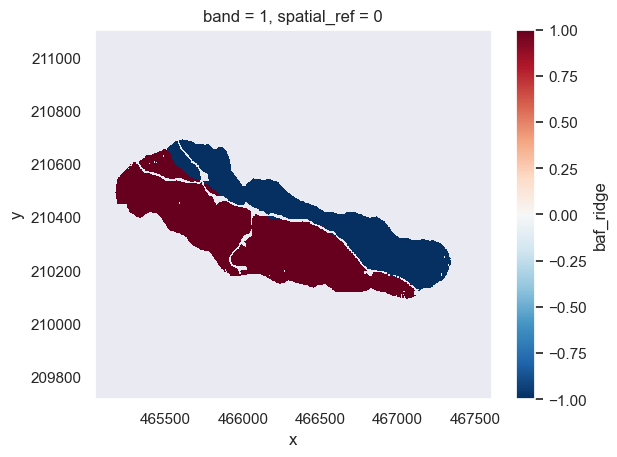

In [31]:
ds['baf_ridge'].plot()

In [32]:
# All the individual baf treatments 
ds['hs_rapid_baf_new_1'] = ds['hs_rapid'].where(ds['baf'] == 1)
ds['hs_rapid_baf_new_2'] = ds['hs_rapid'].where(ds['baf'] == 2)
ds['hs_rapid_baf_new_17'] = ds['hs_rapid'].where(ds['baf'] == 17)
ds['hs_rapid_baf_new_30'] = ds['hs_rapid'].where(ds['baf'] == 30)
ds['hs_rapid_baf_new_32'] = ds['hs_rapid'].where(ds['baf'] == 32)
ds['hs_rapid_baf_new_38'] = ds['hs_rapid'].where(ds['baf'] == 38)
ds['hs_rapid_baf_new_60'] = ds['hs_rapid'].where(ds['baf'] == 60)
ds['hs_rapid_baf_new_69'] = ds['hs_rapid'].where(ds['baf'] == 69)
ds['hs_rapid_baf_new_80'] = ds['hs_rapid'].where(ds['baf'] == 80)
ds['hs_rapid_baf_new_82'] = ds['hs_rapid'].where(ds['baf'] == 82)
ds['hs_rapid_baf_new_90'] = ds['hs_rapid'].where(ds['baf'] == 90)
ds['hs_rapid_baf_new_92'] = ds['hs_rapid'].where(ds['baf'] == 92)
ds['hs_rapid_baf_new_140'] = ds['hs_rapid'].where(ds['baf'] == 140)
ds['hs_rapid_baf_new_150'] = ds['hs_rapid'].where(ds['baf'] == 150)
ds['hs_rapid_baf_new_155'] = ds['hs_rapid'].where(ds['baf'] == 155)

ds['hs_ncalm_baf_new_1'] = ds['hs_ncalm'].where(ds['baf'] == 1)
ds['hs_ncalm_baf_new_2'] = ds['hs_ncalm'].where(ds['baf'] == 2)
ds['hs_ncalm_baf_new_17'] = ds['hs_ncalm'].where(ds['baf'] == 17)
ds['hs_ncalm_baf_new_30'] = ds['hs_ncalm'].where(ds['baf'] == 30)
ds['hs_ncalm_baf_new_32'] = ds['hs_ncalm'].where(ds['baf'] == 32)
ds['hs_ncalm_baf_new_38'] = ds['hs_ncalm'].where(ds['baf'] == 38)
ds['hs_ncalm_baf_new_60'] = ds['hs_ncalm'].where(ds['baf'] == 60)
ds['hs_ncalm_baf_new_69'] = ds['hs_ncalm'].where(ds['baf'] == 69)
ds['hs_ncalm_baf_new_80'] = ds['hs_ncalm'].where(ds['baf'] == 80)
ds['hs_ncalm_baf_new_82'] = ds['hs_ncalm'].where(ds['baf'] == 82)
ds['hs_ncalm_baf_new_90'] = ds['hs_ncalm'].where(ds['baf'] == 90)
ds['hs_ncalm_baf_new_92'] = ds['hs_ncalm'].where(ds['baf'] == 92)
ds['hs_ncalm_baf_new_140'] = ds['hs_ncalm'].where(ds['baf'] == 140)
ds['hs_ncalm_baf_new_150'] = ds['hs_ncalm'].where(ds['baf'] == 150)
ds['hs_ncalm_baf_new_155'] = ds['hs_ncalm'].where(ds['baf'] == 155)

ds['hs_rapid_baf_new_30s'] = ds['hs_rapid'].where(ds['baf_new_grouped'] == 30)
ds['hs_rapid_baf_new_60s'] = ds['hs_rapid'].where(ds['baf_new_grouped'] == 60)
ds['hs_rapid_baf_new_80s'] = ds['hs_rapid'].where(ds['baf_new_grouped'] == 80)
ds['hs_rapid_baf_new_90s'] = ds['hs_rapid'].where(ds['baf_new_grouped'] == 90)
ds['hs_rapid_baf_new_100s'] = ds['hs_rapid'].where(ds['baf_new_grouped'] == 150)

ds['hs_ncalm_baf_new_30s'] = ds['hs_ncalm'].where(ds['baf_new_grouped'] == 30)
ds['hs_ncalm_baf_new_60s'] = ds['hs_ncalm'].where(ds['baf_new_grouped'] == 60)
ds['hs_ncalm_baf_new_80s'] = ds['hs_ncalm'].where(ds['baf_new_grouped'] == 80)
ds['hs_ncalm_baf_new_90s'] = ds['hs_ncalm'].where(ds['baf_new_grouped'] == 90)
ds['hs_ncalm_baf_new_100s'] = ds['hs_ncalm'].where(ds['baf_new_grouped'] == 150)


# now, just make new variables for each aspect, based on the side of the ridge 
# north
ds['hs_rapid_baf_new_1_n'] = ds['hs_rapid_baf_new_1'].where(ds['baf_ridge'] == -1)
ds['hs_rapid_baf_new_2_n'] = ds['hs_rapid_baf_new_2'].where(ds['baf_ridge'] == -1)
ds['hs_rapid_baf_new_17_n'] = ds['hs_rapid_baf_new_17'].where(ds['baf_ridge'] == -1)
ds['hs_rapid_baf_new_30_n'] = ds['hs_rapid_baf_new_30'].where(ds['baf_ridge'] == -1)
ds['hs_rapid_baf_new_32_n'] = ds['hs_rapid_baf_new_32'].where(ds['baf_ridge'] == -1)
ds['hs_rapid_baf_new_38_n'] = ds['hs_rapid_baf_new_38'].where(ds['baf_ridge'] == -1)
ds['hs_rapid_baf_new_60_n'] = ds['hs_rapid_baf_new_60'].where(ds['baf_ridge'] == -1)
ds['hs_rapid_baf_new_69_n'] = ds['hs_rapid_baf_new_69'].where(ds['baf_ridge'] == -1)
ds['hs_rapid_baf_new_80_n'] = ds['hs_rapid_baf_new_80'].where(ds['baf_ridge'] == -1)
ds['hs_rapid_baf_new_82_n'] = ds['hs_rapid_baf_new_82'].where(ds['baf_ridge'] == -1)
ds['hs_rapid_baf_new_90_n'] = ds['hs_rapid_baf_new_90'].where(ds['baf_ridge'] == -1)
ds['hs_rapid_baf_new_92_n'] = ds['hs_rapid_baf_new_92'].where(ds['baf_ridge'] == -1)
ds['hs_rapid_baf_new_140_n'] = ds['hs_rapid_baf_new_140'].where(ds['baf_ridge'] == -1)
ds['hs_rapid_baf_new_150_n'] = ds['hs_rapid_baf_new_150'].where(ds['baf_ridge'] == -1)
ds['hs_rapid_baf_new_155_n'] = ds['hs_rapid_baf_new_155'].where(ds['baf_ridge'] == -1)

# south 
ds['hs_rapid_baf_new_1_s'] = ds['hs_rapid_baf_new_1'].where(ds['baf_ridge'] == 1)
ds['hs_rapid_baf_new_2_s'] = ds['hs_rapid_baf_new_2'].where(ds['baf_ridge'] == 1)
ds['hs_rapid_baf_new_17_s'] = ds['hs_rapid_baf_new_17'].where(ds['baf_ridge'] == 1)
ds['hs_rapid_baf_new_30_s'] = ds['hs_rapid_baf_new_30'].where(ds['baf_ridge'] == 1)
ds['hs_rapid_baf_new_32_s'] = ds['hs_rapid_baf_new_32'].where(ds['baf_ridge'] == 1)
ds['hs_rapid_baf_new_38_s'] = ds['hs_rapid_baf_new_38'].where(ds['baf_ridge'] == 1)
ds['hs_rapid_baf_new_60_s'] = ds['hs_rapid_baf_new_60'].where(ds['baf_ridge'] == 1)
ds['hs_rapid_baf_new_69_s'] = ds['hs_rapid_baf_new_69'].where(ds['baf_ridge'] == 1)
ds['hs_rapid_baf_new_80_s'] = ds['hs_rapid_baf_new_80'].where(ds['baf_ridge'] == 1)
ds['hs_rapid_baf_new_82_s'] = ds['hs_rapid_baf_new_82'].where(ds['baf_ridge'] == 1)
ds['hs_rapid_baf_new_90_s'] = ds['hs_rapid_baf_new_90'].where(ds['baf_ridge'] == 1)
ds['hs_rapid_baf_new_92_s'] = ds['hs_rapid_baf_new_92'].where(ds['baf_ridge'] == 1)
ds['hs_rapid_baf_new_140_s'] = ds['hs_rapid_baf_new_140'].where(ds['baf_ridge'] == 1)
ds['hs_rapid_baf_new_150_s'] = ds['hs_rapid_baf_new_150'].where(ds['baf_ridge'] == 1)
ds['hs_rapid_baf_new_155_s'] = ds['hs_rapid_baf_new_155'].where(ds['baf_ridge'] == 1)

# grouped
ds['hs_rapid_baf_new_30s_n'] = ds['hs_ncalm_baf_new_30s'].where(ds['baf_ridge'] == -1)
ds['hs_rapid_baf_new_60s_n'] = ds['hs_ncalm_baf_new_60s'].where(ds['baf_ridge'] == -1)
ds['hs_rapid_baf_new_80s_n'] = ds['hs_ncalm_baf_new_80s'].where(ds['baf_ridge'] == -1)
ds['hs_rapid_baf_new_90s_n'] = ds['hs_ncalm_baf_new_90s'].where(ds['baf_ridge'] == -1)
ds['hs_rapid_baf_new_100s_n'] = ds['hs_ncalm_baf_new_100s'].where(ds['baf_ridge'] == -1)

ds['hs_rapid_baf_new_30s_s'] = ds['hs_ncalm_baf_new_30s'].where(ds['baf_ridge'] == 1)
ds['hs_rapid_baf_new_60s_s'] = ds['hs_ncalm_baf_new_60s'].where(ds['baf_ridge'] == 1)
ds['hs_rapid_baf_new_80s_s'] = ds['hs_ncalm_baf_new_80s'].where(ds['baf_ridge'] == 1)
ds['hs_rapid_baf_new_90s_s'] = ds['hs_ncalm_baf_new_90s'].where(ds['baf_ridge'] == 1)
ds['hs_rapid_baf_new_100s_s'] = ds['hs_ncalm_baf_new_100s'].where(ds['baf_ridge'] == 1)

Now, save to a netcdf to use for future analysis.

In [33]:
ds.to_netcdf('C:\\Users\\Lumbr\\OneDrive - UW/Documents\\Washington\\EasternCascades\\Python\\CER_treatment_manuscript\\cer_treatment_region_dataset_all_variables.nc') 